### Text Classification -- Ask Historians vs. Ask Science

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,classification

from yellowbrick.text import FreqDistVisualizer
from nltk.corpus import stopwords
import requests
import time
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re


### Data Acquisition

In [8]:
# create function to retrieve subreddit posts
def get_reddit_posts(subreddit, pages):
    url = "https://www.reddit.com/r/" + subreddit + ".json"
    headers = {'User-agent':'Time Bandit'}
    after = None
    posts = []
    for j in range(pages):
        if after==None:
            params = {}
        else:
            params = {'after':after}
        print(j)  # just to keep track of progress while it is running
        res = requests.get(url,params=params, headers=headers)
        if res.status_code==200:
            the_json = res.json()
            for i in range(len(the_json['data']['children'])):
                posts.append({'subreddit': the_json['data']['children'][i]['data']['subreddit'],
                                  'name':the_json['data']['children'][i]['data']['name'],
                                  'title':the_json['data']['children'][i]['data']['title'],
                              'text':the_json['data']['children'][i]['data']['selftext'],
                              'url':the_json['data']['children'][i]['data']['url'],
                                 'is_self': the_json['data']['children'][i]['data']['is_self']})
            after = the_json['data']['after']
        else:
            print(res.status_code)
            break
        time.sleep(1)
    return pd.DataFrame(posts)    

In [10]:
# Get posts -- commented out so we don't re-run it.
# df=get_reddit_posts('AskHistorians',40)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [11]:
df.to_pickle('./data/askhistorians.pkl')

In [2]:
df_science = pd.read_pickle('./data/science.pkl')

In [3]:
df = pd.read_pickle('./data/askhistorians.pkl')

### Data Cleaning

In [4]:
df = pd.concat([df, df_science])
df = df.reset_index(drop=True)
df.subreddit.value_counts()

askscience       1001
AskHistorians     997
Name: subreddit, dtype: int64

In [5]:
df['is_self'].value_counts()

True     1997
False       1
Name: is_self, dtype: int64

In [7]:
# remove cases with blank text
df = df[df['text']!='']

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.shape

(1338, 6)

In [10]:
# calculate baseline
df.subreddit.value_counts(normalize=True)

AskHistorians    0.510463
askscience       0.489537
Name: subreddit, dtype: float64

In [11]:
df['text'] = df['text'] +' '+ df['title']

In [12]:
# Binarize label column
df['science'] = df['subreddit'].apply(lambda x: 1 if x == 'askscience' else 0)

# get rid of \n,  and &amp in text
df['text'] = df['text'].map(lambda x: x.replace('\n',' '))

df['text'] = df['text'].map(lambda x: x.replace('&amp;','and'))

In [13]:
# Load stopwords from NLTK and add custom words
mystopwords = stopwords.words('english')
mystopwords.extend(['like','would','get','x200b','https','one','www','com','org','etc','could'])

### Modeling: Logistic Regression

In [14]:
X = df['text']  # X will be turned into a matrix
y = df['science']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [18]:
# Logistic Regression model with Count Vectorizer
cvec = CountVectorizer(stop_words=mystopwords,max_features=None, ngram_range=(1,1))

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

lr = LogisticRegression(penalty='l2',solver='liblinear',C=1)

lr.fit(X_train_cvec, y_train)

print('Logistic Regression model with Count Vectorizer')
# Training score
print(f'Train score: {lr.score(X_train_cvec, y_train):.3f}')

# Test score
print(f'Test score: {lr.score(X_test_cvec, y_test):.3f}')

Logistic Regression model with Count Vectorizer
Train score: 1.000
Test score: 0.949


In [21]:
# Logistic Regression model with TF-IDF Vectorizer
tvec = TfidfVectorizer(stop_words=mystopwords,max_features=None, ngram_range=(1,1))

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

lr = LogisticRegression(penalty='l2',solver='liblinear',C=1)

lr.fit(X_train_tvec, y_train)

print('Logistic Regression model with TF-IDF Vectorizer')
# Training score
print(f'Train score: {lr.score(X_train_tvec, y_train):.3f}')

# Test score
print(f'Test score: {lr.score(X_test_tvec, y_test):.3f}')

Logistic Regression model with TF-IDF Vectorizer
Train score: 0.999
Test score: 0.961


### Modeling: Naive Bayes and SVM Models

In [22]:
# set up X, y for Naive Bayes and SVM Models
X = df[['text']]  # X is a pd Dataframe
y = df['science']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [29]:
cvec = CountVectorizer(stop_words=None,max_features=None,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.01)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Bernoulli model with Count Vectorizer
Train data accuracy: 0.999
Test data accuracy: 0.961


In [30]:
cvec = CountVectorizer(stop_words=None,max_features=4000,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=.5)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Multinomial model with Count Vectorizer
Train data accuracy: 0.991
Test data accuracy: 0.970


In [44]:
tvec = TfidfVectorizer(stop_words=None,max_features=3000,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=2)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Multinomial model with TF-IDF Vectorizer
Train data accuracy: 0.987
Test data accuracy: 0.973


### Analyze Best Model Results

In [46]:
# print confusion matrix
y_pred = nb.predict(X_test_tvec)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['predict neg', 'predict pos'], index=['actual neg', 'actual pos'])
cm_df

,predict neg,predict pos
actual neg,166,5
actual pos,4,160


In [47]:
# add predicted and actual y to test dataset
X_test['y_test'] = pd.Series(y_test, index=X_test.index)
X_test['y_pred'] = pd.Series(y_pred, index=X_test.index)

import re
# count words in text
X_test['word_count'] = pd.Series([len(re.findall(r'\w+', x)) for x in X_test.text], index=X_test.index)

C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [48]:
# list false positives - predicted Science but actually History
mask = (X_test['y_test']==0) & (X_test['y_pred'] ==1)
X_test[mask]

,text,y_test,y_pred,word_count
574,Can languages still be created till today? Mor...,0,1,75
369,Hey! What are some of the coolest careers som...,0,1,58
726,Weird question ik. But would the people in cha...,0,1,42
58,"To explain, it wasn't that long ago that human...",0,1,50
685,/r/AskFakeHistorians is winding down. To ensur...,0,1,82


In [49]:
X_test.text.loc[685]

'/r/AskFakeHistorians is winding down. To ensure things are mostly back to normal by April 2nd, we are now closing any new thread posted to April Fools answers. They will be removed, and repeat posters temporarily banned. You may continue to post joke responses in existing threads posted before this announcement. We now return to our regularly scheduled program. All threads posted after this announcement are OFF LIMITS for /r/AskFakeHistorians. You may continue to post in those before this cut off.'

In [53]:
X_test.text.loc[369]

"Hey!  What are some of the coolest careers someone with a history degree (or a master's or doctorate) could pursue? I'm investigating to see if something cool catches my eye. Bonus points for any careers someone suggests with either a high income or a lot of cool experiences and/or traveling.  Thanks guys! :) Cool Historian Careers?"

In [54]:
X_test.text.loc[58]

"To explain, it wasn't that long ago that humans walked alongside mammoths and smilodons. Is there any sort of evidence that humans from early civilization had any knowledge of these animals, through oral tradition or whatever? Does all human knowledge of the Pleistocene Megafauna come from the fossil record?"

In [83]:
X_test['word_count'].mean()

63.54

In [84]:
X_test['word_count'][mask].mean()

56.214285714285715

In [50]:
# list false negatives
mask = (X_test['y_test']==1) & (X_test['y_pred'] ==0)
X_test[mask]

,text,y_test,y_pred,word_count
1114,And do people in the different types of coma h...,1,0,67
1365,I'm currently writing an essay on colour in di...,1,0,61
1337,The Greek and the Romans (and I'm sure other c...,1,0,97
1064,Why are they much smaller today ? Im wondering...,1,0,31


In [52]:
X_test.text.loc[1365]

"I'm currently writing an essay on colour in dinosaurs and I found a paper stating that Non-avian dinosaurs had Biliverdin in their eggshells  https://www.nature.com/articles/s41586-018-0646-5 and I was wondering if it was actually used as a pigment in any living animal.   Is Biliverdin used as a pigment in anything other than eggshells?"

In [51]:
X_test.text.loc[1337]

"The Greek and the Romans (and I'm sure other cultures too) seem to have had an amazing level of knowledge and wisdom in a wide variety of fields. They created things like the Baghdad Battery, the Antikythera Mechanism, special cements which helped create Aquaeducts that are still around millenia later. Also knowledge about astronomy, the human body and many other things I forgot about (pun bad, but intended). Many things took centuries to be re-discovered.   How does this happen and what else might we have collectively forgotten over time? How do societies/cultures 'lose knowledge'?"

In [55]:
X_test.text.loc[1064]

'Why are they much smaller today ? Im wondering as to why all the Birds ,Insects and Fish were very large back in the mesozoic age compared to what they are now?'

In [87]:
X_test['word_count'][mask].mean()

64.4

In [65]:
tvec = TfidfVectorizer(stop_words=None,max_features=4000,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=.3)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Multinomial model with TF-IDF Vectorizer
Train data accuracy: 0.994
Test data accuracy: 0.944


In [56]:
tvec = TfidfVectorizer(stop_words=None,max_features=4000, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.003)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Bernoulli model with TF-IDF Vectorizer
Train data accuracy: 0.981
Test data accuracy: 0.922


In [56]:
# SVM model
cvec = CountVectorizer(stop_words=mystopwords,max_features=800, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())
# Instantiate SVM.
# svc = svm.SVC(kernel='poly', C = 1.8, gamma = .05) 
svc = svm.SVC(kernel='rbf', C = 15, gamma = .001)  

# Fit on training data.
svc.fit(X_train_cvec,y_train)

# Score model on the training set.
print('Support Vector Machine model with Count Vectorizer')
print(f'Train data accuracy: {svc.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {svc.score(X_test_cvec,y_test):.3f}')

Support Vector Machine model with Count Vectorizer
Train data accuracy: 0.959
Test data accuracy: 0.907


### Data Visualization and EDA

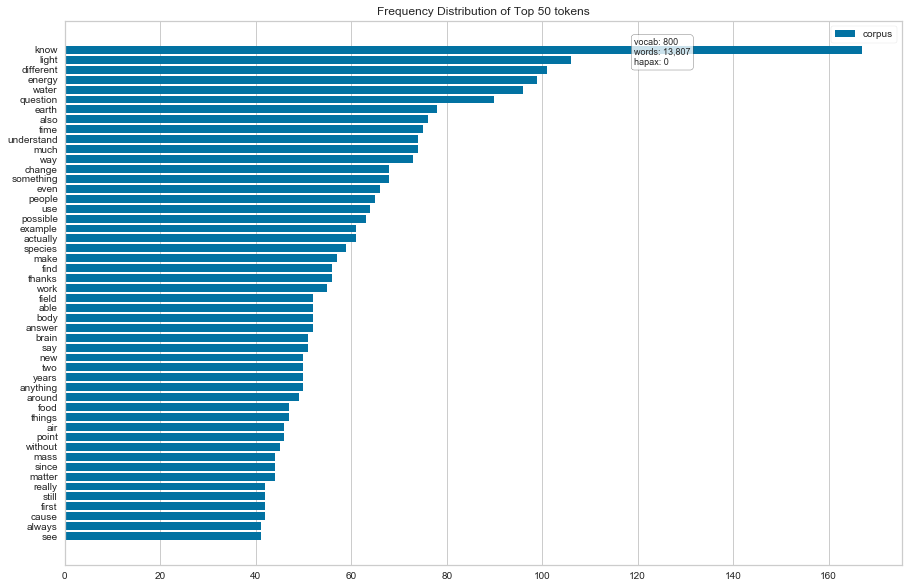

In [57]:
# https://www.scikit-yb.org/en/latest/api/text/freqdist.html
mask       = (df['science'] == 1)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features,n=50,)
visualizer.fit(docs)
visualizer.poof()

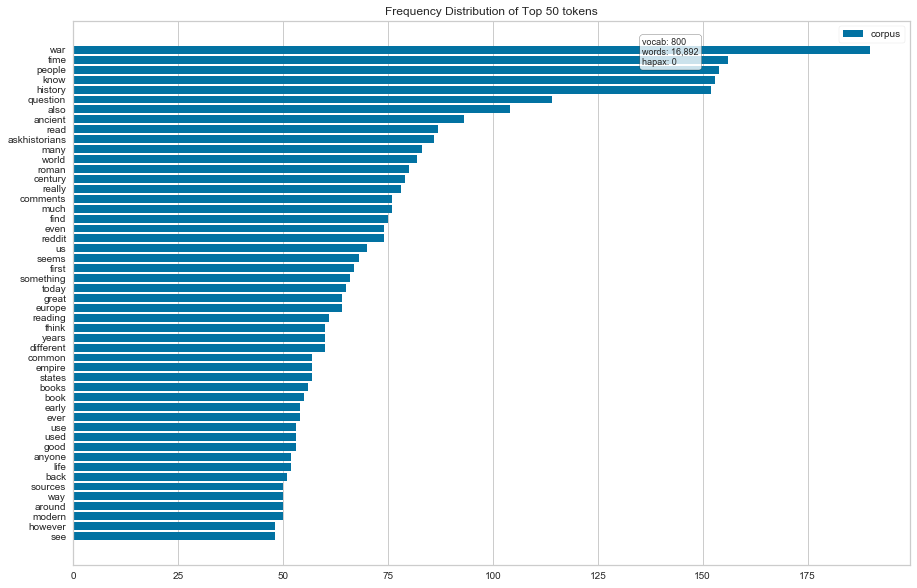

In [59]:
mask       = (df['science'] == 0)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features,n=50,kwargs={'color':'r'})
visualizer.fit(docs)
visualizer.poof()

In [60]:
# Define function to create wordclouds
def make_wc(mask):
    # use visualizer to create word frequency list for Wordcloud
    # (it is also possible to let wordcloud create the list)
    docs       = cvec.fit_transform(text for text in df['text'][mask])
    features   = cvec.get_feature_names()
    #create dataframe of word frequencies
    word_freq = pd.DataFrame({'word':features,'freq':list(visualizer.count(docs))})
    word_freq = word_freq.sort_values(by = ['freq'],ascending=False)
    # convert df into dict
    w_dict = dict([(word_freq['word'].iloc[i],word_freq['freq'].iloc[i]) for i in range(len(word_freq))])
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width=1000,height=500,scale=1,background_color="white").generate_from_frequencies(w_dict)
    # Display the generated image:
    plt.rcParams['figure.figsize'] = (20, 10)
    fig = plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.tight_layout(pad=0)
    plt.axis("off")
    plt.show()
    return fig

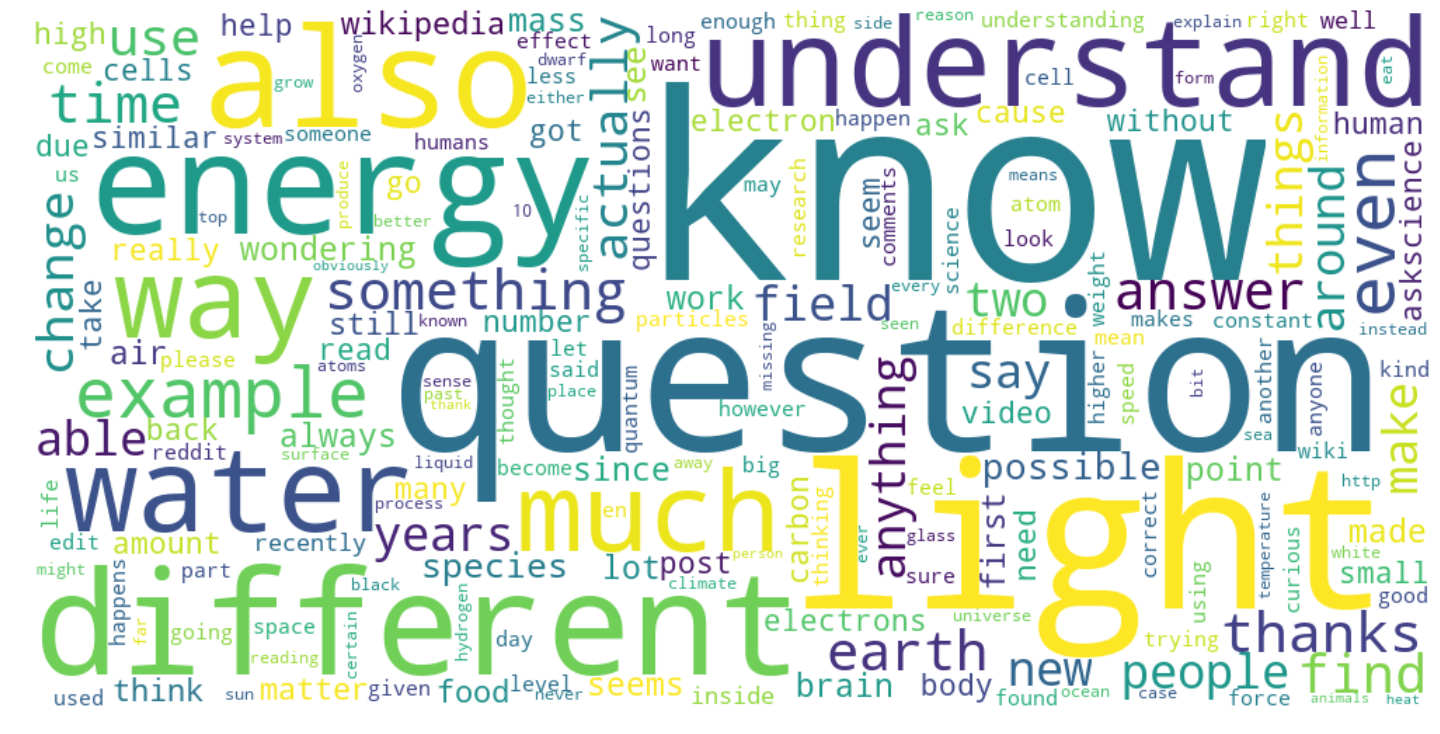

In [105]:
# make science wordcloud
mask = (df['science'] == 1)  # select which subreddit to use
name = 'science'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png', bbox_inches='tight');

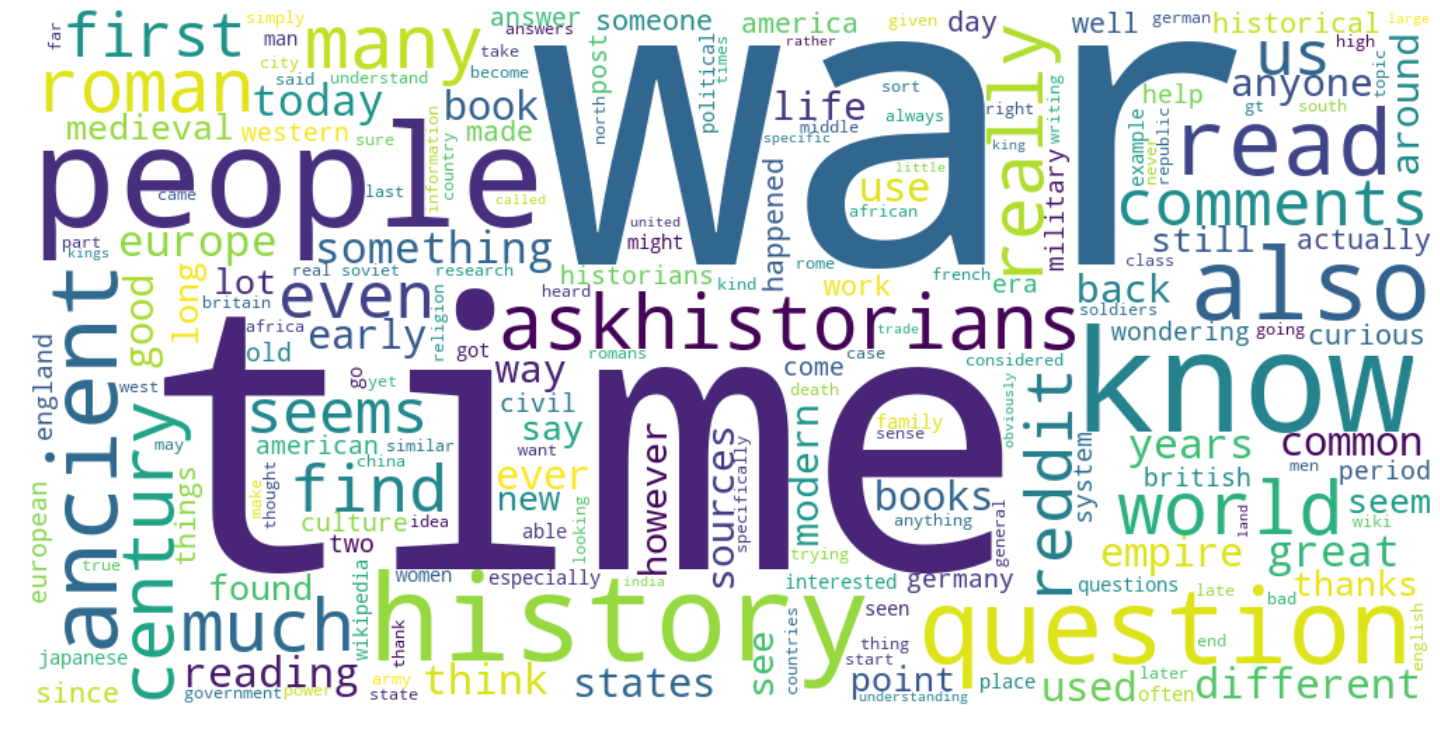

In [61]:
# make history wordcloud
mask = (df['science'] == 0)  # select which subreddit to use
name = 'history'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png', bbox_inches='tight');